## Midterm

In [8]:
from pyeda.inter import *
import pyeda
import pydot
import graphviz
import pandas as pd
%load_ext gvmagic

The gvmagic extension is already loaded. To reload it, use:
  %reload_ext gvmagic


## Convert rows to binary formula

In [2]:
def convert_row_to_formula(row):
    row_formula = ['~'*abs(row[i]-1) + f'x{i}' for i in range(len(row))]
    return ' & '.join(row_formula)

def convert_bin_formula(R):
    r_formulas = []
    for row in R.iterrows():
        r_formula = convert_row_to_formula(row[1])
        r_formulas.append(r_formula)
    return ' | '.join(r_formulas)

## Convert p into BDD

In [3]:
def make_bdd(lst):
    binaries = []
    for i in range(32):
        if i in lst:
            bins = bin(i)[2:].zfill(5)
            binaries.append([int(k) for k in bins])

    primes = pd.DataFrame(binaries, columns=['x'+str(i) for i in range(len(binaries[0]))])

    expression = convert_bin_formula(primes)

    f = expr(expression)
    f = expr2bdd(f)
    return f

def output_bdd_graph(bdd, filename):
    dot_bdd = bdd.to_dot()
    
    with open(f"{filename}.dot", "w") as file:
        file.write(dot_bdd)
        
    (graph,) = pydot.graph_from_dot_file(f'{filename}.dot')
    graph.write_png(f'{filename}.png')


## Define CTL checker for EF and EG

In [9]:
def check(relations, p, var_dict, model='EF'):
    Hk = p
    Hk_1 = relations
    while Hk is not Hk_1:
        Hk_1 = Hk
        frontier = (Hk_1.compose(var_dict) & relations)
        for rhs_var in var_dict.values():
            frontier = (frontier.restrict({rhs_var: 1})) | (frontier.restrict({rhs_var: 0}))
        if model == 'EF':
            Hk = Hk_1 | frontier
        elif model == 'EG':
            Hk = p & frontier
    return Hk

## main.py

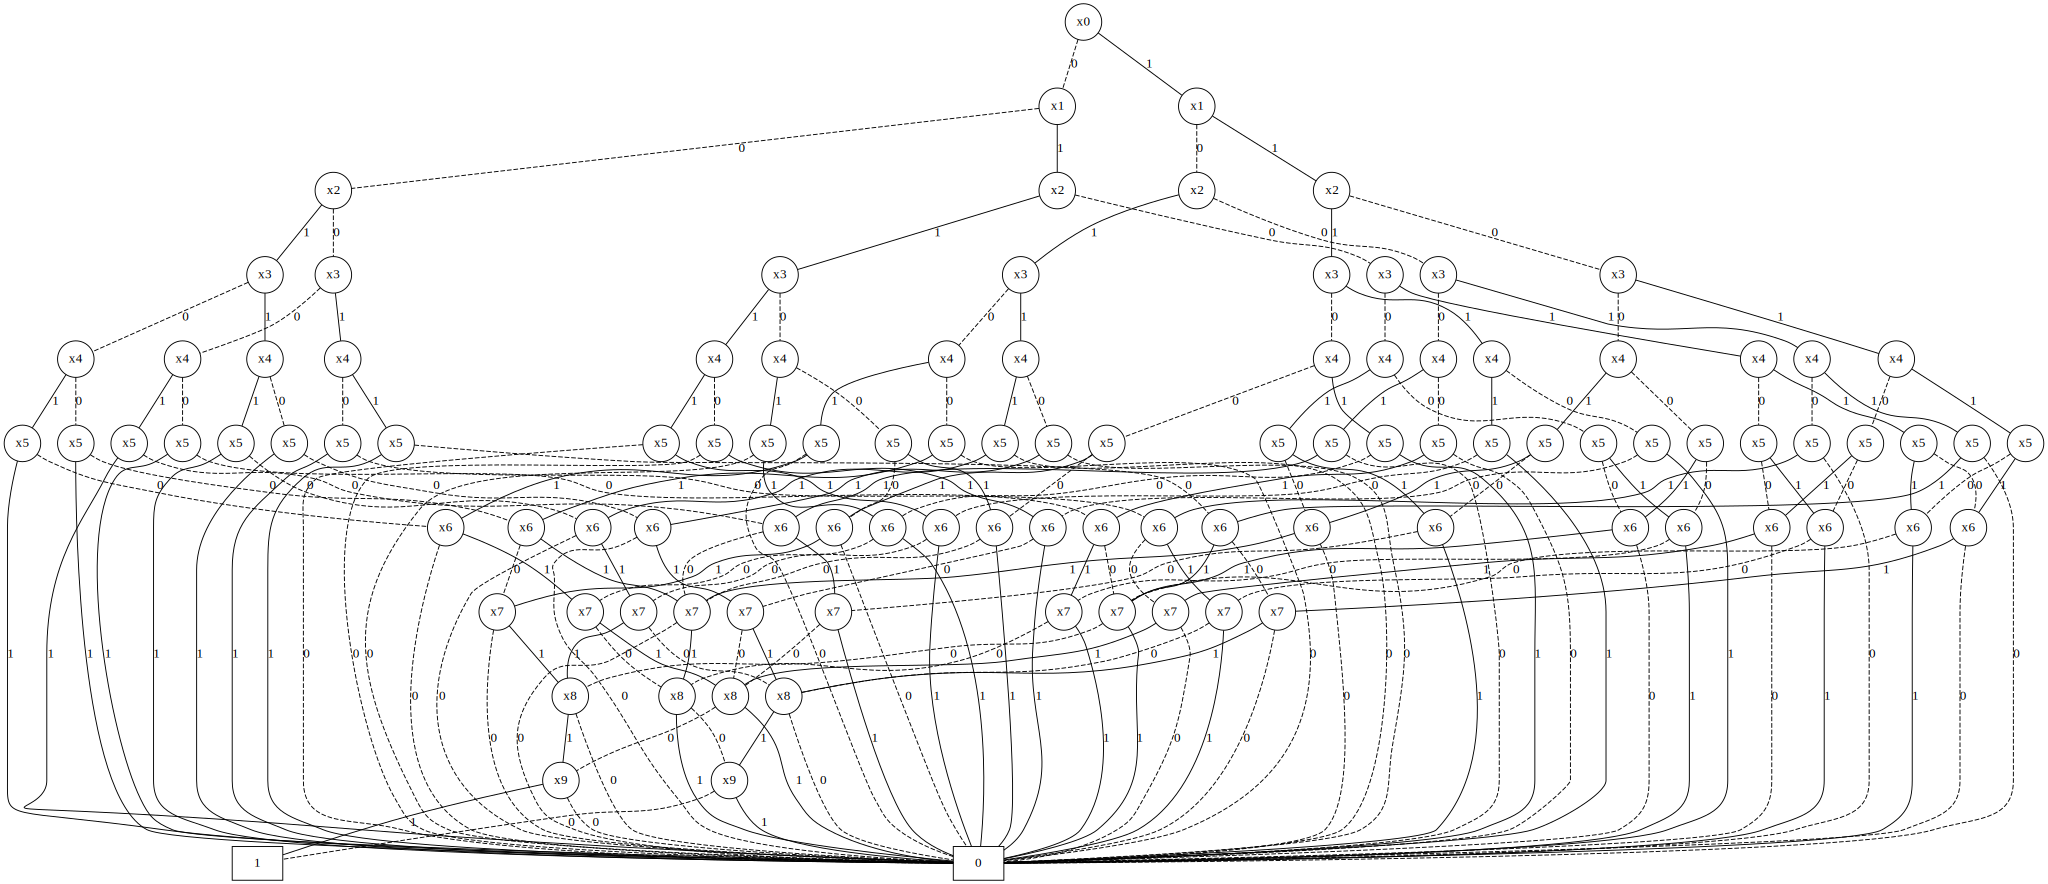

In [5]:
# Save edges of graph
expressions = []  
binaries = []
for i in range(32):
    for j in range(32):
        if (i+3)%32 == j%32 or (i+8)%32 == j%32:
            expression = (i, j)
            bins = bin(i)[2:].zfill(5)
            bins += bin(j)[2:].zfill(5)
            binaries.append([int(k) for k in bins])
            expressions.append(expression)
            
R = pd.DataFrame(binaries, columns=['x'+str(i) for i in range(10)])

# convert edge to binary formula
expression = convert_bin_formula(R)

f_relation = expr(expression)
f_relation = expr2bdd(f_relation)

output_bdd_graph(f_relation, 'bdd_midterm')

%dotobj f_relation

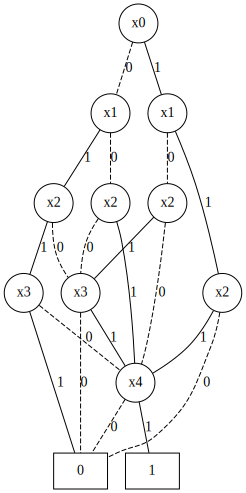

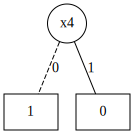

In [6]:
prime_numbers = [3,5,7,11,13,17,19,23,29,31]
even_numbers = [i for i in range(32) if i%2 == 0]
f_primes = make_bdd(prime_numbers)
f_evens = make_bdd(even_numbers)
output_bdd_graph(f_primes, 'primes')
output_bdd_graph(f_evens, 'evens')


%dotobj f_primes
%dotobj f_evens

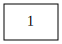

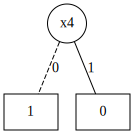

In [10]:
x0, x1, x2, x3, x4, x5, x6, x7, x8, x9 = map(bddvar, [f'x{i}' for i in range(10)])

var_dict = {x0:x5, x1:x6, x2:x7, x3:x8, x4:x9}
EFPrime = check(f_relation, f_primes, var_dict)
%dotobj EFPrime

even_and_EFPrime = f_evens & EFPrime
EG = check(f_relation, even_and_EFPrime, var_dict, model='EG')
%dotobj EG

output_bdd_graph(EG, 'EG_even_EFprime')

Example

In [27]:
R = ['000010','010000','100000','011000','110100','100001','010001','001011','101001','101111','111110','111011','110011']
Rs = []
for s in R:
    Rs.append([int(e) for e in s])
    
R = pd.DataFrame(Rs)
expression = convert_bin_formula(R)
x0, x1, x2, x3, x4, x5 = map(bddvar, [f'x{i}' for i in range(R.shape[1])])

f = expr(expression)
f = expr2bdd(f)
f.to_dot()
#%dotobj f

ex_f = expr2bdd(expr('x0 & ~x1 & ~x2 | x0 & ~x1 & x2'))
ex_f = expr2bdd(expr('~x0 & ~x1 | ~x0 & x1 & ~x2 | x0 & ~x1 & ~x2'))
#%dotobj ex_f

1
[{x0: 0, x1: 0}, {x0: 0, x1: 1, x2: 0}, {x0: 1, x1: 0, x2: 0}]
[{x0: 0, x2: 0}, {x0: 1, x1: 0, x2: 0}]
2
[{x0: 0, x2: 0}, {x0: 1, x1: 0, x2: 0}]
[{x0: 0, x2: 0}, {x0: 1, x1: 0, x2: 0}]


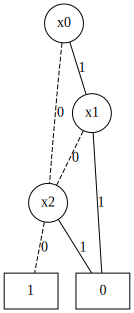

In [28]:
var_dict = {x0:x3, x1:x4, x2:x5}
EFPrime = check(f, ex_f, var_dict, model='EG')
%dotobj EFPrime

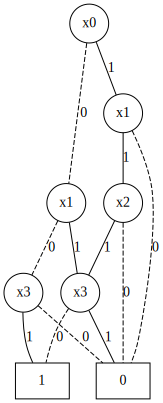

In [8]:
R = [[0,0,0,1], [0,1,1,0], [1,0,0,0], [1,1,1,0], [0,1,1,1]]
R = [[0,0,0,1], [0,1,1,0], [0,0,1,1], [1,1,1,0], [0,1,0,0]]
R = pd.DataFrame(R)
expression = convert_bin_formula(R)
x0, x1, x2, x3 = map(bddvar, [f'x{i}' for i in range(4)])

f = expr(expression)
f = expr2bdd(f)
f.to_dot()
%dotobj f

In [9]:

var_dict = {x0:x2, x1:x3}
EFPrime = EFp(f, f_primes, var_dict)
%dotobj EFPrime

NameError: name 'f_primes' is not defined

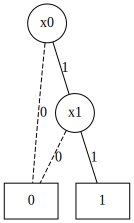

In [4]:
binaries = []
prime_numbers = [3,5,7,11,13,17,19,23,29,31]
for i in range(4):
    if i in prime_numbers:
        bins = bin(i)[2:].zfill(2)
        binaries.append([int(k) for k in bins])
        
primes = pd.DataFrame(binaries, columns=['x'+str(i) for i in range(len(binaries[0]))])
primes.head()

primes_expression = convert_bin_formula(primes)
primes_expression

f_primes = expr(primes_expression)
f_primes = expr2bdd(f_primes)

h_primes = f_primes.to_dot()

%dotobj f_primes

## Problem 4

Make even BDD

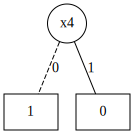

In [29]:
binaries = []
for i in range(32):
    if i %2 == 0:
        bins = bin(i)[2:].zfill(5)
        binaries.append([int(k) for k in bins])
        
evens = pd.DataFrame(binaries, columns=['x'+str(i) for i in range(len(binaries[0]))])

evens_expression = convert_bin_formula(evens)

f_evens = expr(evens_expression)
f_evens = expr2bdd(f_evens)

h_evens = f_evens.to_dot()

with open("evens.dot", "w") as file:
    file.write(h_evens)
    
(graph,) = pydot.graph_from_dot_file('evens.dot')
graph.write_png('evens.png')

%dotobj f_evens

Make prime BDD

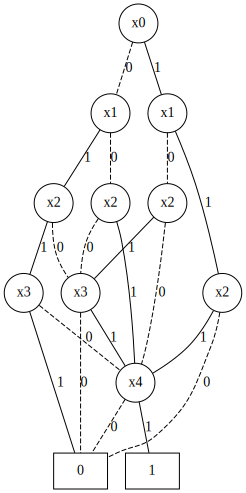

In [31]:
binaries = []
prime_numbers = [3,5,7,11,13,17,19,23,29,31]
for i in range(32):
    if i in prime_numbers:
        bins = bin(i)[2:].zfill(5)
        binaries.append([int(k) for k in bins])
        
primes = pd.DataFrame(binaries, columns=['x'+str(i) for i in range(len(binaries[0]))])

primes_expression = convert_bin_formula(primes)

f_primes = expr(primes_expression)
f_primes = expr2bdd(f_primes)

h_primes = f_primes.to_dot()

with open("primes.dot", "w") as file:
    file.write(h_primes)
    
(graph,) = pydot.graph_from_dot_file('primes.dot')
graph.write_png('primes.png')

%dotobj f_primes

Make relation BDD

In [32]:
x0, x1, x2, x3, x4, x5, x6, x7, x8, x9 = map(bddvar, [f'x{i}' for i in range(10)])

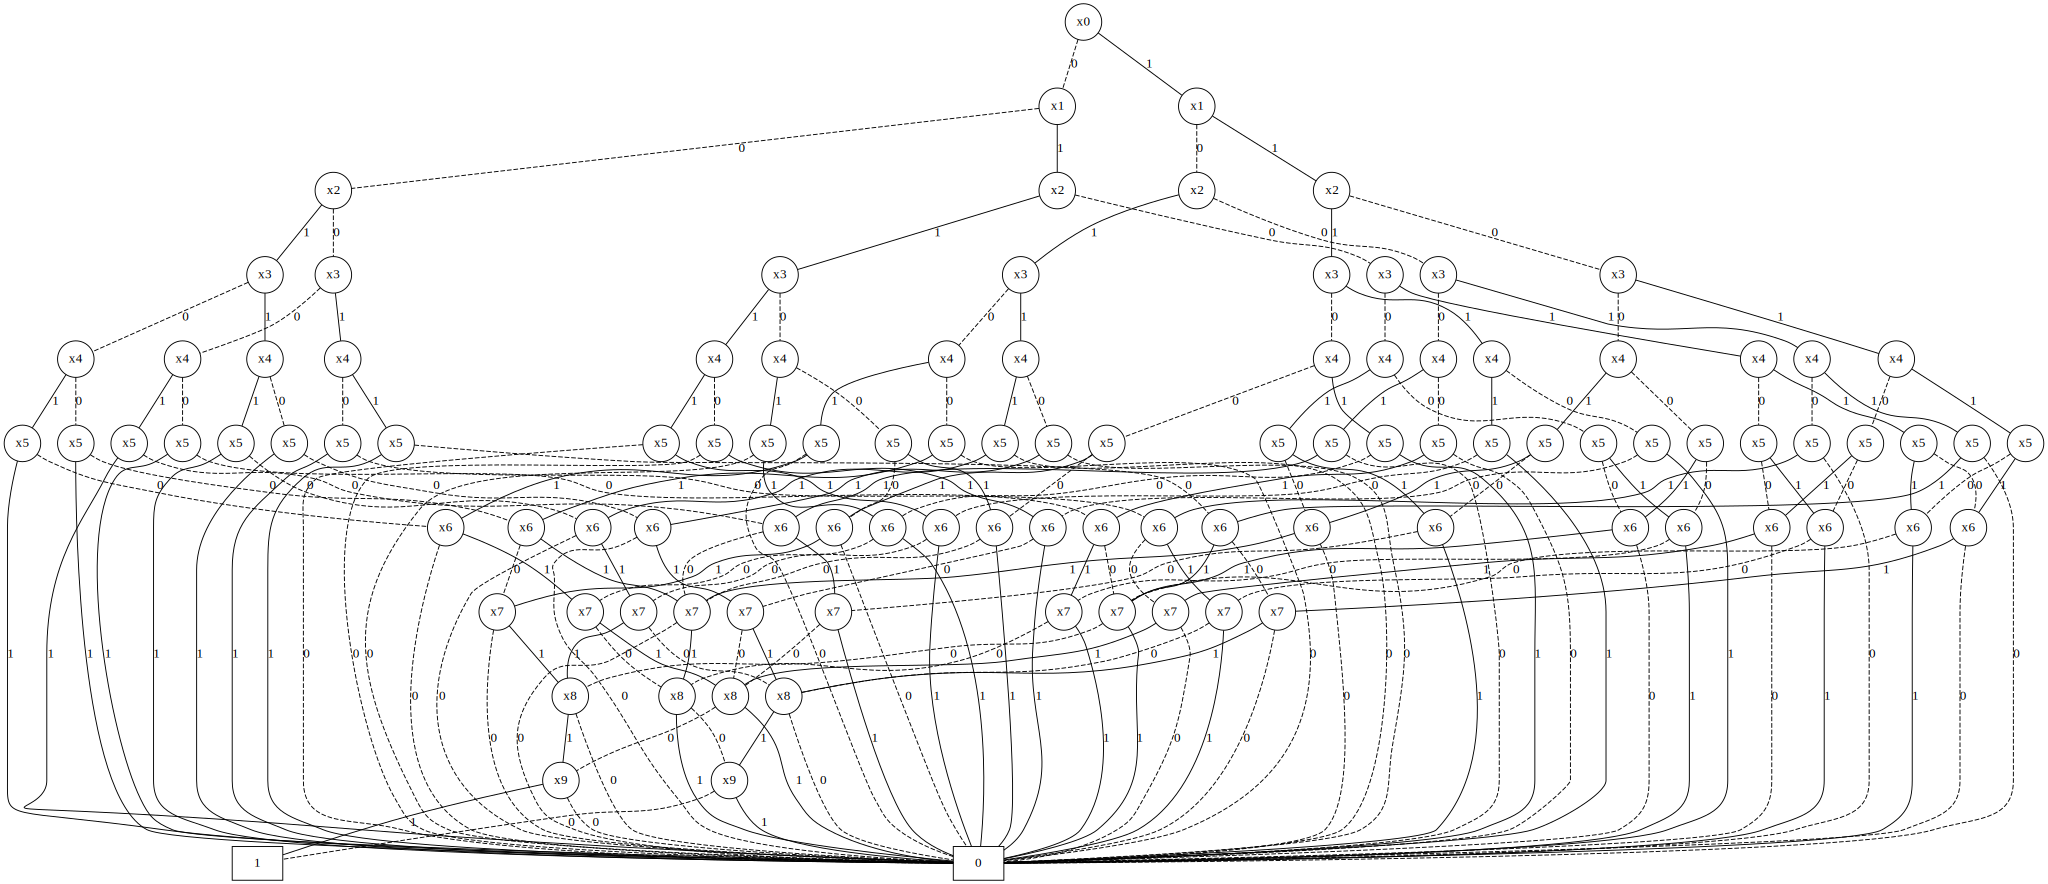

In [33]:
expressions = []  
binaries = []
for i in range(32):
    for j in range(32):
        if (i+3)%32 == j%32 or (i+8)%32 == j%32:
            expression = (i, j)
            bins = bin(i)[2:].zfill(5)
            bins += bin(j)[2:].zfill(5)
            binaries.append([int(k) for k in bins])
            expressions.append(expression)
            
R = pd.DataFrame(binaries, columns=['x'+str(i) for i in range(10)])

expression = convert_bin_formula(R)

f_relation = expr(expression)
f_relation = expr2bdd(f_relation)
h_relation = f_relation.to_dot()

with open("bdd_midterm.dot", "w") as file:
    file.write(h_relation)
    
(graph,) = pydot.graph_from_dot_file('bdd_midterm.dot')
graph.write_png('bdd_midterm.png')

%dotobj f_relation

1
[{x0: 0, x1: 0, x2: 0, x3: 1, x4: 1}, {x0: 0, x1: 0, x2: 1, x4: 1}, {x0: 0, x1: 1, x2: 0, x3: 1, x4: 1}, {x0: 0, x1: 1, x2: 1, x3: 0, x4: 1}, {x0: 1, x1: 0, x2: 0, x4: 1}, {x0: 1, x1: 0, x2: 1, x3: 1, x4: 1}, {x0: 1, x1: 1, x2: 1, x4: 1}]
[{x0: 0, x1: 0, x2: 0, x3: 0, x4: 0}, {x0: 0, x1: 0, x2: 0, x3: 1}, {x0: 0, x1: 0, x2: 1, x3: 0}, {x0: 0, x1: 0, x2: 1, x3: 1, x4: 1}, {x0: 0, x1: 1, x2: 0}, {x0: 0, x1: 1, x2: 1, x3: 0, x4: 1}, {x0: 0, x1: 1, x2: 1, x3: 1}, {x0: 1, x1: 0, x3: 0}, {x0: 1, x1: 0, x3: 1, x4: 1}, {x0: 1, x1: 1, x2: 0, x3: 1}, {x0: 1, x1: 1, x2: 1, x3: 0}, {x0: 1, x1: 1, x2: 1, x3: 1, x4: 1}]
2
[{x0: 0, x1: 0, x2: 0, x3: 0, x4: 0}, {x0: 0, x1: 0, x2: 0, x3: 1}, {x0: 0, x1: 0, x2: 1, x3: 0}, {x0: 0, x1: 0, x2: 1, x3: 1, x4: 1}, {x0: 0, x1: 1, x2: 0}, {x0: 0, x1: 1, x2: 1, x3: 0, x4: 1}, {x0: 0, x1: 1, x2: 1, x3: 1}, {x0: 1, x1: 0, x3: 0}, {x0: 1, x1: 0, x3: 1, x4: 1}, {x0: 1, x1: 1, x2: 0, x3: 1}, {x0: 1, x1: 1, x2: 1, x3: 0}, {x0: 1, x1: 1, x2: 1, x3: 1, x4: 1}]
[{x0: 0

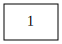

1
[{x4: 0}]
[{x4: 0}]


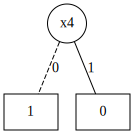

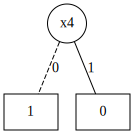

In [42]:
x0, x1, x2, x3, x4, x5, x6, x7, x8, x9 = map(bddvar, [f'x{i}' for i in range(10)])

var_dict = {x0:x5, x1:x6, x2:x7, x3:x8, x4:x9}
EFPrime = check(f_relation, f_primes, var_dict)
%dotobj EFPrime

even_and_EFPrime = f_evens & EFPrime
var_dict = {x0:x5, x1:x6, x2:x7, x3:x8, x4:x9}
EG = check(f_relation, even_and_EFPrime, var_dict, model='EG')
%dotobj EG

EG_dot = EG.to_dot()

with open("EG_even_EFprime.dot", "w") as file:
    file.write(EG_dot)
    
(graph,) = pydot.graph_from_dot_file('EG_even_EFprime.dot')
graph.write_png('EG_even_EFprime.png')

1
[{x4: 0}]
[{x4: 0}]


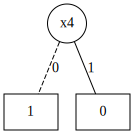

In [40]:
eg2 = check(f_relation, f_evens, var_dict, model='EG')



%dotobj eg2